In [18]:
#default_exp train_adjacent

In [19]:
#export
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

In [20]:
column='SeriesInstanceUID'

In [21]:
df_series = Meta.df_any

In [22]:
df_series

,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,...,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
SOPInstanceUID,,,,,,,,,,,,,,,,,,,,,
ID_4509f2560,CT,ID_4c16e232,ID_c174374b07,ID_002c9733b7,,-125.0,1.0,1,MONOCHROME2,512,...,1.0,40.0,1.0,80.0,0,0,0,0,0,0
ID_0969176c0,CT,ID_4c16e232,ID_c174374b07,ID_002c9733b7,,-125.0,1.0,1,MONOCHROME2,512,...,1.0,40.0,1.0,80.0,0,0,0,0,0,0
ID_2363aa3ef,CT,ID_4c16e232,ID_c174374b07,ID_002c9733b7,,-125.0,1.0,1,MONOCHROME2,512,...,1.0,40.0,1.0,80.0,0,0,0,0,0,0
ID_7b6119ddf,CT,ID_4c16e232,ID_c174374b07,ID_002c9733b7,,-125.0,1.0,1,MONOCHROME2,512,...,1.0,40.0,1.0,80.0,0,0,0,0,0,0
ID_a787384c2,CT,ID_4c16e232,ID_c174374b07,ID_002c9733b7,,-125.0,1.0,1,MONOCHROME2,512,...,1.0,40.0,1.0,80.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_8eb7c45bc,CT,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_cf66e9f08,CT,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_6c779d850,CT,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [23]:
fn = get_pil_fn(path_jpg256)

In [24]:
sop = 'ID_0969176c0'
idx = df_series.index.get_loc(sop)

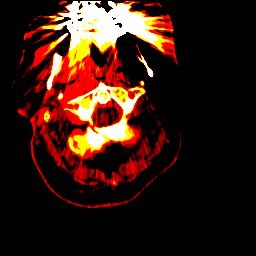

In [25]:
img = fn(sop)
img

In [26]:
# sid = df_series.loc[sop].SeriesInstanceUID
# prev_row = df_series.iloc[idx-1]
# prev_item = df_series.index[idx-1]
# prev_row

# tt = ToTensor()

# # if prev_row.SeriesInstanceUID == sid:
# prev = tt(fn(prev_item))

In [27]:
list(range(1,2))

[1]

In [28]:
#export
class TfmSlice:
    def __init__(self, df, path, windowed=False, num_adj=1): 
        self.fn = get_pil_fn(path)
        self.tt = ToTensor()
        self.df = df
        self.windowed = windowed
        self.num_adj = num_adj
        
    def get_adj(self, idx, x_mid, sid_mid):
        if idx < 0 or idx >= self.df.shape[0] \
        or  self.df.iloc[idx].SeriesInstanceUID != sid_mid:
            return torch.zeros_like(x_mid)
        adj_item = self.df.index[idx]
        return self.tt(self.fn(adj_item))
        
    def __call__(self, item):
        idx = self.df.index.get_loc(item)
        sid = self.df.loc[item].SeriesInstanceUID
        x = self.tt(self.fn(item))
        x_prevs, x_nexts = [], []
        for i in range(1, self.num_adj+1):
            x_prevs.append(self.get_adj(idx-i, x, sid)[:1])
            x_nexts.append(self.get_adj(idx+i, x, sid)[:1])
        x = x if self.windowed else x[:1]
        
        return TensorCTScan(torch.cat([*x_prevs, x, *x_nexts]))

In [45]:
tfm = TfmSlice(Meta.df_comb, path_jpg256, windowed=True)
tfm(sop).shape

torch.Size([5, 256, 256])

In [40]:
tfm = TfmSlice(Meta.df_comb, path_jpg256, num_adj=2)
tfm(sop).shape

torch.Size([5, 256, 256])

In [41]:
dsrc = DataSource(Meta.df_comb.index, [[tfm],[fn2label,EncodedMultiCategorize(htypes)]], splits=Meta.splits_stg1)

In [42]:
dsrc[10][0].shape

torch.Size([5, 256, 256])

In [43]:
x,y = dsrc[10]

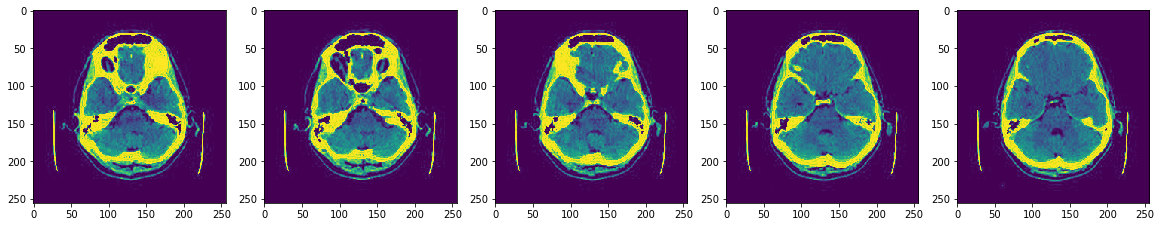

In [44]:
f, ax = plt.subplots(1,5,figsize=(20,20))
for idx,c in enumerate(x):
    ax[idx].imshow(c)

In [46]:
#export
mean_5c = [mean[0], *mean, mean[0]]
std_5c = [std[0], *std, std[0]]

mean_adj = [mean[0]]*3
std_adj = [std[0]]*3

## Train

In [51]:
#export
def get_adj_data(bs, sz, splits, img_dir=path_jpg256, windowed=False, num_adj=1, df=Meta.df_comb, test=False):
    tfm = TfmSlice(df, img_dir, windowed=windowed, num_adj=num_adj)
    num_c = (1+2*num_adj)
    mean,std = ([mean[0]]*num_c, [std[0]]*num_c) if windowed else (mean_5c, std_5c)
    return get_data_gen(L(list(df.index)), bs=bs, img_tfm=tfm, sz=sz, splits=splits,
                       mean=mean, std=std, test=test)

In [20]:
dbunch = get_adj_data(512, 128, Meta.splits_stg1, windowed=False)

In [21]:
xb, yb = dbunch.one_batch()
xb.shape, yb.shape

(torch.Size([512, 5, 128, 128]), torch.Size([512, 6]))

In [30]:
learn = get_learner(dbunch, partial(xresnet18, c_in=5))

In [ ]:
do_fit(learn, 1, 4e-2)

## Test

In [26]:
#export
def get_adj_test_data(bs=512, sz=256, tst_dir='tst_jpg', windowed=False):
    tst_fns = Meta.df_tst.index.values
    tst_splits = [L.range(tst_fns), L.range(tst_fns)]
    tst_dbch = get_adj_data(bs, sz, tst_splits, path/tst_dir, df=Meta.df_tst, windowed=windowed, test=True)
#     tst_dbch = get_data_gen(tst_fns, bs=bs, img_tfm=get_pil_fn(path/tst_dir), sz=sz, splits=tst_splits, test=True)
    tst_dbch.c = 6
    return tst_dbch

In [27]:
dbunch_tst = get_adj_test_data(512, 128)

In [33]:
xb, = dbunch_tst.one_batch()
xb.shape

torch.Size([512, 5, 128, 128])

## Export

In [52]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_metadata.ipynb.
Converted 01_preprocess.ipynb.
Converted 01_preprocess_mean_std.ipynb.
Converted 02_train.ipynb.
Converted 03_train3d.ipynb.
Converted 03_train3d_01_train3d.ipynb.
Converted 03_train3d_01b_train_lstm.ipynb.
Converted 03_train3d_02_train_head.ipynb.
Converted 03_trainfull3d.ipynb.
Converted 04_trainSeq_01_lstm.ipynb.
Converted 04_trainSeq_02_transformer.ipynb.
Converted 04_trainSeq_03_lstm_seutao.ipynb.
Converted 05_train_adjacent.ipynb.
Converted 05_train_adjacent_01_5c_windowed.ipynb.
Converted 05_train_adjacent_01_5slice.ipynb.
Converted 05_train_adjacent_02_3c.ipynb.
Converted 05_train_adjacent_02_3c_stg1.ipynb.
Converted 06_seutao_features.ipynb.
Converted 06_seutao_features_01_simple_lstm_20ep.ipynb.
Converted 06_seutao_features_01b_simple_lstm_10ep.ipynb.
Converted 06_seutao_features_01c_simple_lstm_meta.ipynb.
Converted 06_seutao_features_01d_simple_lstm_meta_fulldataset.ipynb.
Converted 06_seutao_features_02_2ndPlace.ipynb.
Converted 06_seutao_featu